# Examples of running IHPF 

In [80]:
## Import scripts for the dimension reduction methods 
import IHPF
import INMF 
import schpf
from sklearn.decomposition import PCA

In [48]:
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

In [388]:
# datasets = ['10Xmouse','humanpancreas','10Xpbmc']
datasets = ['10Xmouse']

## IHPF 

In [ ]:
for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby('batch'):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = IHPF.scIHPF(no_cell_types,max_iter=500)
    model.fit(Xlist,dataset_ratio=0.1)
    adata.obsm['IHPF'] = np.concatenate(model.cell_scores(),axis=0)
    adata.varm['IHPF'] = model.shared_gene_scores()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF']))
    adata.obs['IHPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['IHPF_max'] = np.argmax(adata.obsm['IHPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))
    

Clipping dp: was [7.050768545013852e-06, 8.257898116426077e-06, 7.804119377397e-06] now [5.125247407704592e-07, 4.083773528691381e-07, 4.393301496747881e-07]
[Iter.    0]  loss:89.469641  pct:100.000000000
[Iter.   10]  loss:6.578422  pct:-92.647313534
[Iter.   20]  loss:6.502860  pct:-1.148629457
[Iter.   30]  loss:6.401582  pct:-1.557451612
[Iter.   40]  loss:6.376951  pct:-0.384760228
[Iter.   50]  loss:6.361311  pct:-0.245263046
[Iter.   60]  loss:6.334075  pct:-0.428142719
[Iter.   70]  loss:6.313144  pct:-0.330453219
[Iter.   80]  loss:6.303784  pct:-0.148257899
[Iter.   90]  loss:6.298786  pct:-0.079294231
[Iter.  100]  loss:6.295485  pct:-0.052393589
[Iter.  110]  loss:6.293180  pct:-0.036624747
[Iter.  120]  loss:6.291370  pct:-0.028763150
[Iter.  130]  loss:6.289859  pct:-0.024010438
[Iter.  140]  loss:6.288721  pct:-0.018093858
[Iter.  150]  loss:6.287863  pct:-0.013647847
[Iter.  160]  loss:6.287185  pct:-0.010783585
[Iter.  170]  loss:6.286649  pct:-0.008515064
[Iter.  180

## INMF 

In [404]:
from INMF import INMF

In [405]:
class scINMF:
    def __init__(self, k, alpha=1, **kwargs):
        np.random.seed(0)
        self.n_components = k
        self.method = INMF(
            n_components=self.n_components, solver="mu", alpha=alpha, **kwargs
        )

    def fit(self, X):
        self.data = X
        (
            self.cell_scores,
            self.shared_gene_scores,
            self.dataset_gene_scores,
        ) = self.method.fit_transform(self.data)


In [406]:
for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby('batch'):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scINMF(no_cell_types,alpha=1,max_iter=500)
    model.fit(Xlist)
    adata.obsm['INMF'] = np.concatenate(model.cell_scores,axis=0)
    adata.varm['INMF'] = model.shared_gene_scores.transpose()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF']))
    adata.obs['INMF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['INMF_max'] = np.argmax(adata.obsm['INMF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Reconstruction error 75028.04665185406


## HPF

In [ ]:
from schpf import scHPF
from scipy.sparse import vstack

In [ ]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby('batch'):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scHPF(no_cell_types,max_iter=500)
    model.fit(vstack(Xlist))
    adata.obsm['HPF'] = model.cell_score()
    adata.varm['HPF'] = model.gene_score()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['HPF']))
    adata.obs['HPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['HPF_max'] = np.argmax(adata.obsm['HPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

## PCA

In [ ]:
class scPCA:
    def __init__(self, k):
        from sklearn.decomposition import TruncatedSVD

        np.random.seed(0)
        self.n_components = k
        self.method = TruncatedSVD(n_components=self.n_components)

    def fit(self, X):
        self.data = X
        self.method.fit(self.data)
        self.cell_score = self.method.transform(self.data)
        self.gene_score = self.method.components_.transpose()

In [ ]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby('batch'):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scPCA(no_cell_types)
    model.fit(vstack(Xlist))
    adata.obsm['PCA'] = model.cell_score
    adata.varm['PCA'] = model.gene_score
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['PCA']))
    adata.obs['PCA_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['PCA_max'] = np.argmax(adata.obsm['PCA'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [397]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))

In [398]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [399]:
batchputriy = dict()
actualputriy = dict()

for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        le = preprocessing.LabelEncoder()
        batchlabel = le.fit_transform(adata.obs[batch_labels])
        le = preprocessing.LabelEncoder()
        actuallabel = le.fit_transform(adata.obs[cell_labels])
        no_cell_types = len(adataobs[cell_labels].unique())
        batch[method] = np.sum(np.max(confusion_matrix(batchlabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
        actual[method] = np.sum(np.max(confusion_matrix(actuallabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
    actual['batch'] =  np.sum(np.max(confusion_matrix(actuallabel,batchlabel),axis=1)) / len(adata.obs[cell_labels])
    batchputriy[dataset] = batch
    actualputriy[dataset] = actual

In [400]:
np.round(pd.DataFrame(actualputriy),3)

,10Xmouse
HPF,0.764
IHPF,0.766
INMF,0.728
PCA,0.764
batch,0.644


In [ ]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        batch[method] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_kmeans_normalised'.format(method)])
        actual[method] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_kmeans_normalised'.format(method)])
    batch['actual'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    actual['batch'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [ ]:
np.round(pd.DataFrame(actualAMI),3)

## Heatmap of cluster labels with actual labels

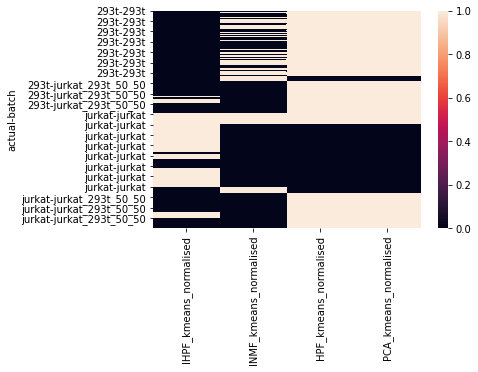

In [403]:
import seaborn as sns
clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
sns.heatmap(clustered)

## For species data

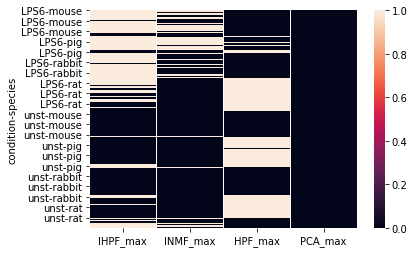

In [286]:
import seaborn as sns
clustered = adata.obs[['condition','species','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['condition','species']).sort_index()
sns.heatmap(clustered)

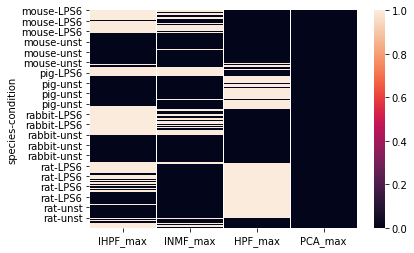

In [287]:
import seaborn as sns
clustered = adata.obs[['condition','species','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['species','condition',]).sort_index()
sns.heatmap(clustered)

## TSNE plots

In [320]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [321]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        adata.obsm['{}_TSNE'.format(method)] = TSNE(n_jobs=60).fit_transform(normalize(adata.obsm[method]))
    adata.write('../Data/{}.h5ad'.format(dataset))

## TSNE plot 

In [301]:
import seaborn as sb
import matplotlib.pyplot as plt

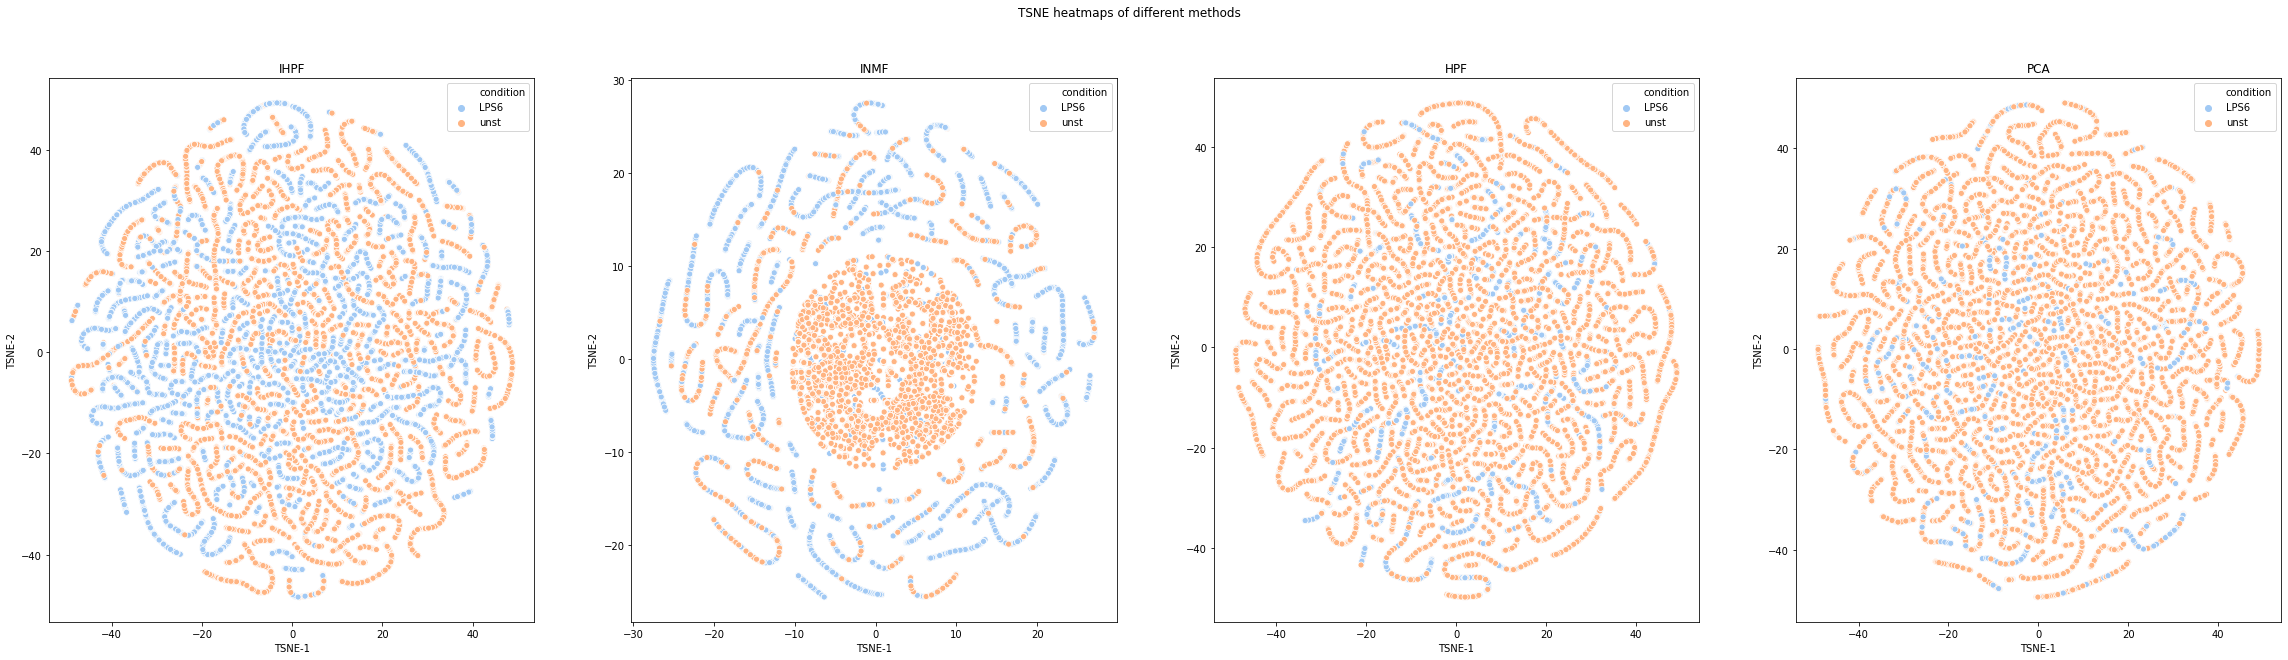

In [306]:
f, axes = plt.subplots(1, 4, figsize=(40, 10), sharex=False)
f.suptitle('TSNE heatmaps of different methods')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc','species']
i = 0
for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual'   
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs['condition'],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(method))
    i = i + 1

## Hyper-parameter search

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']
batch_labels = 'batch'
cell_labels = 'actual'

In [324]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby('batch'):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = scINMF(no_cell_types,alpha=1/l,max_iter=500)
        model.fit(Xlist)
        adata.obsm['INMF_{}'.format(l)] = np.concatenate(model.cell_scores,axis=0)
        adata.varm['INMF_{}'.format(l)] = model.shared_gene_scores.transpose()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF_{}'.format(l)]))
        adata.obs['INMF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['INMF_{}_max'.format(l)] = np.argmax(adata.obsm['INMF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Reconstruction error 107301.809757123
Reconstruction error 89561.63005417839
Reconstruction error 75028.04665185406
Reconstruction error 34836.40112184095
Reconstruction error 113456.1743305214
Reconstruction error 113450.18618405776
Reconstruction error 113390.14133442429
Reconstruction error 112794.51490439025
Reconstruction error 1343903.849758864
Reconstruction error 1148841.4078672866
Reconstruction error 1120212.068773359
Reconstruction error 808453.0124237628
Reconstruction error 1417768.1657990795
Reconstruction error 1417732.0750516525
Reconstruction error 1417034.522187934
Reconstruction error 1409779.896818065
Reconstruction error 55428.34986534603
Reconstruction error 45496.79350597574
Reconstruction error 39113.86003364466
Reconstruction error 22143.075093860647
Reconstruction error 57816.915338674764
Reconstruction error 57820.92140574453
Reconstruction error 57852.88513439814
Reconstruction error 57831.31026318283


In [325]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby('batch'):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = IHPF.scIHPF(no_cell_types,max_iter=500)
        model.fit(Xlist,dataset_ratio=l)
        adata.obsm['IHPF_{}'.format(l)] = np.concatenate(model.cell_scores(),axis=0)
        adata.varm['IHPF_{}'.format(l)] = model.shared_gene_scores()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF_{}'.format(l)]))
        adata.obs['IHPF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['IHPF_{}_max'.format(l)] = np.argmax(adata.obsm['IHPF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Clipping dp: was [7.050768545013852e-06, 8.257898116426077e-06, 7.804119377397e-06] now [5.125247407704592e-07, 4.083773528691381e-07, 4.393301496747881e-07]
[Iter.    0]  loss:89.469641  pct:100.000000000
[Iter.   10]  loss:6.578422  pct:-92.647313534
[Iter.   20]  loss:6.502860  pct:-1.148629457
[Iter.   30]  loss:6.401582  pct:-1.557451612
[Iter.   40]  loss:6.376951  pct:-0.384760228
[Iter.   50]  loss:6.361311  pct:-0.245263046
[Iter.   60]  loss:6.334075  pct:-0.428142719
[Iter.   70]  loss:6.313144  pct:-0.330453219
[Iter.   80]  loss:6.303784  pct:-0.148257899
[Iter.   90]  loss:6.298786  pct:-0.079294231
[Iter.  100]  loss:6.295485  pct:-0.052393589
[Iter.  110]  loss:6.293180  pct:-0.036624747
[Iter.  120]  loss:6.291370  pct:-0.028763150
[Iter.  130]  loss:6.289859  pct:-0.024010438
[Iter.  140]  loss:6.288721  pct:-0.018093858
[Iter.  150]  loss:6.287863  pct:-0.013647847
[Iter.  160]  loss:6.287185  pct:-0.010783585
[Iter.  170]  loss:6.286649  pct:-0.008515064
[Iter.  180

[Iter.  180]  loss:7.607163  pct:-0.004494907
[Iter.  190]  loss:7.606806  pct:-0.004702532
[Iter.  200]  loss:7.606429  pct:-0.004948262
[Iter.  210]  loss:7.606074  pct:-0.004674286
[Iter.  220]  loss:7.605768  pct:-0.004025721
[Iter.  230]  loss:7.605489  pct:-0.003659547
[Iter.  240]  loss:7.605228  pct:-0.003434267
[Iter.  250]  loss:7.604957  pct:-0.003558691
[Iter.  260]  loss:7.604681  pct:-0.003631086
[Iter.  270]  loss:7.604389  pct:-0.003837704
[Iter.  280]  loss:7.604087  pct:-0.003979690
[Iter.  290]  loss:7.603789  pct:-0.003909842
[Iter.  300]  loss:7.603546  pct:-0.003195503
[Iter.  310]  loss:7.603359  pct:-0.002469432
[Iter.  320]  loss:7.603234  pct:-0.001640228
[Iter.  330]  loss:7.603162  pct:-0.000952948
[Iter.  340]  loss:7.603125  pct:-0.000477585
converged
Clipping dp: was [7.050768545013852e-06, 8.257898116426077e-06, 7.804119377397e-06] now [5.125247407704592e-07, 4.083773528691381e-07, 4.393301496747881e-07]
[Iter.    0]  loss:90.580782  pct:100.000000000
[I

[Iter.  330]  loss:125.676873  pct:-0.004217184
[Iter.  340]  loss:125.670773  pct:-0.004853326
[Iter.  350]  loss:125.666295  pct:-0.003563597
[Iter.  360]  loss:125.662905  pct:-0.002697671
[Iter.  370]  loss:125.659560  pct:-0.002661761
[Iter.  380]  loss:125.657097  pct:-0.001959890
[Iter.  390]  loss:125.654779  pct:-0.001844919
[Iter.  400]  loss:125.652696  pct:-0.001658149
[Iter.  410]  loss:125.650709  pct:-0.001581116
[Iter.  420]  loss:125.648285  pct:-0.001929155
[Iter.  430]  loss:125.646165  pct:-0.001686865
[Iter.  440]  loss:125.644122  pct:-0.001626162
[Iter.  450]  loss:125.639557  pct:-0.003633041
[Iter.  460]  loss:125.636844  pct:-0.002159440
[Iter.  470]  loss:125.633651  pct:-0.002542059
[Iter.  480]  loss:125.629946  pct:-0.002948590
[Iter.  490]  loss:125.627207  pct:-0.002180438
Clipping dp: was [2.054972355836071e-06, 2.5971088689402677e-05, 6.098692392697558e-05, 3.414987759242649e-07, 4.0265252465587764e-08] now [1.030316692776978e-06, 2.0419471547938884e-0

[Iter.  390]  loss:132.840563  pct:-0.030443341
[Iter.  400]  loss:132.798932  pct:-0.031338747
[Iter.  410]  loss:132.769577  pct:-0.022105010
[Iter.  420]  loss:132.712515  pct:-0.042978331
[Iter.  430]  loss:132.632159  pct:-0.060549056
[Iter.  440]  loss:132.561580  pct:-0.053214017
[Iter.  450]  loss:132.505016  pct:-0.042670064
[Iter.  460]  loss:132.460810  pct:-0.033361333
[Iter.  470]  loss:132.421280  pct:-0.029842672
[Iter.  480]  loss:132.332321  pct:-0.067178755
[Iter.  490]  loss:132.295588  pct:-0.027758262
Clipping dp: was [2.054972355836071e-06, 2.5971088689402677e-05, 6.098692392697558e-05, 3.414987759242649e-07, 4.0265252465587764e-08] now [1.030316692776978e-06, 2.0419471547938884e-07, 4.648955073207617e-07, 2.013995617744513e-08, 4.222342795401346e-09]
[Iter.    0]  loss:3765.380895  pct:100.000000000
[Iter.   10]  loss:180.196505  pct:-95.214388396
[Iter.   20]  loss:147.584532  pct:-18.098005120
[Iter.   30]  loss:143.168096  pct:-2.992479435
[Iter.   40]  loss:1

[Iter.  440]  loss:128.094892  pct:-0.006851265
[Iter.  450]  loss:128.083179  pct:-0.009143699
[Iter.  460]  loss:128.075381  pct:-0.006088323
[Iter.  470]  loss:128.068319  pct:-0.005514264
[Iter.  480]  loss:128.062443  pct:-0.004587624
[Iter.  490]  loss:128.057703  pct:-0.003701725
Clipping dp: was [6.436535841203295e-06, 3.839864075416699e-05, 0.00032666671904735267, 3.0550894734915346e-05, 1.657276698097121e-05, 2.1401105186669156e-05, 2.6043688194477e-05, 4.086319313501008e-05] now [8.50793533027172e-06, 5.628217943012714e-06, 1.1423210380598902e-06, 7.932272739708423e-06, 8.732348680496216e-06, 9.302051737904549e-06, 6.67881453409791e-06, 7.523953914642334e-06]
[Iter.    0]  loss:146.895451  pct:100.000000000
[Iter.   10]  loss:21.340718  pct:-85.472172588
[Iter.   20]  loss:20.685425  pct:-3.070618775
[Iter.   30]  loss:20.278897  pct:-1.965290353
[Iter.   40]  loss:20.065959  pct:-1.050044760
[Iter.   50]  loss:19.970101  pct:-0.477714850
[Iter.   60]  loss:19.907281  pct:-0

[Iter.  440]  loss:19.633814  pct:-0.002014870
[Iter.  450]  loss:19.633501  pct:-0.001598033
[Iter.  460]  loss:19.633189  pct:-0.001588235
[Iter.  470]  loss:19.632844  pct:-0.001754136
[Iter.  480]  loss:19.632563  pct:-0.001431347
[Iter.  490]  loss:19.632374  pct:-0.000964488
Clipping dp: was [6.436535841203295e-06, 3.839864075416699e-05, 0.00032666671904735267, 3.0550894734915346e-05, 1.657276698097121e-05, 2.1401105186669156e-05, 2.6043688194477e-05, 4.086319313501008e-05] now [8.50793533027172e-06, 5.628217943012714e-06, 1.1423210380598902e-06, 7.932272739708423e-06, 8.732348680496216e-06, 9.302051737904549e-06, 6.67881453409791e-06, 7.523953914642334e-06]
[Iter.    0]  loss:131.046104  pct:100.000000000
[Iter.   10]  loss:20.516628  pct:-84.343961975
[Iter.   20]  loss:20.418037  pct:-0.480541139
[Iter.   30]  loss:20.153716  pct:-1.294546907
[Iter.   40]  loss:19.968972  pct:-0.916676295
[Iter.   50]  loss:19.848603  pct:-0.602779367
[Iter.   60]  loss:19.785155  pct:-0.31965

[Iter.    0]  loss:152.050116  pct:100.000000000
[Iter.   10]  loss:25.338018  pct:-83.335745428
[Iter.   20]  loss:21.039300  pct:-16.965488250
[Iter.   30]  loss:20.345995  pct:-3.295283789
[Iter.   40]  loss:20.113824  pct:-1.141115126
[Iter.   50]  loss:20.007206  pct:-0.530074312
[Iter.   60]  loss:19.942691  pct:-0.322458865
[Iter.   70]  loss:19.899564  pct:-0.216254879
[Iter.   80]  loss:19.869651  pct:-0.150319144
[Iter.   90]  loss:19.847707  pct:-0.110439804
[Iter.  100]  loss:19.830525  pct:-0.086569069
[Iter.  110]  loss:19.817380  pct:-0.066284712
[Iter.  120]  loss:19.806637  pct:-0.054212101
[Iter.  130]  loss:19.797969  pct:-0.043764613
[Iter.  140]  loss:19.790799  pct:-0.036214817
[Iter.  150]  loss:19.784843  pct:-0.030095855
[Iter.  160]  loss:19.779960  pct:-0.024677574
[Iter.  170]  loss:19.775991  pct:-0.020065045
[Iter.  180]  loss:19.772462  pct:-0.017848329
[Iter.  190]  loss:19.769039  pct:-0.017310154
[Iter.  200]  loss:19.766498  pct:-0.012853276
[Iter.  2

In [326]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'INMF_max', 'HPF_max', 'PCA_max', 'INMF_0.1_kmeans_normalised', 'INMF_0.1_max', 'INMF_0.5_kmeans_normalised', 'INMF_0.5_max', 'INMF_1.0_kmeans_normalised', 'INMF_1.0_max', 'INMF_10.0_kmeans_normalised', 'INMF_10.0_max', 'INMF_1e-05_kmeans_normalised', 'INMF_1e-05_max', 'INMF_0.0001_kmeans_normalised', 'INMF_0.0001_max', 'INMF_0.001_kmeans_normalised', 'INMF_0.001_max', 'INMF_0.01_kmeans_normalised', 'INMF_0.01_max', 'IHPF_0.1_kmeans_normalised', 'IHPF_0.1_max', 'IHPF_0.5_kmeans_normalised', 'IHPF_0.5_max', 'IHPF_1.0_kmeans_normalised', 'IHPF_1.0_max', 'IHPF_10.0_kmeans_normalised', 'IHPF_10.0_max', 'IHPF_1e-05_kmeans_normalised', 'IHPF_1e-05_max', 'IHPF_0.0001_kmeans_normalised', 'IHPF_0.0001_max', 'IHPF_0.001_kmeans_normalised', 'IHPF_0.001_max', 'IHPF_0.01_kmeans_normalised', 'IHPF_0.01_max'
    obsm: 'HPF'

In [375]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc', 'species']

In [376]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual'        
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for method in ['IHPF','INMF']:
        for l in hyper_parameter_space:
            batch[(method,l)] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
            actual[(method,l)] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [377]:
np.round(pd.DataFrame(actualAMI),3)

10Xmouse  humanpancreas  10Xpbmc  species
IHPF 0.10000      0.050          0.276    0.478    0.325
     0.50000      0.049          0.317    0.375    0.039
     1.00000      0.006          0.335    0.341    0.077
     10.00000     0.000          0.281    0.238    0.022
     0.00001      0.287          0.292    0.746    0.117
     0.00010      0.287          0.298    0.693    0.260
     0.00100      0.256          0.323    0.614    0.302
     0.01000      0.072          0.240    0.582    0.241
INMF 0.10000      0.132          0.208    0.260    0.167
     0.50000      0.130          0.213    0.262    0.184
     1.00000      0.125          0.200    0.172    0.157
     10.00000     0.130          0.204    0.159    0.170
     0.00001      0.132          0.102    0.341    0.156
     0.00010      0.132          0.127    0.341    0.156
     0.00100      0.132          0.137    0.339    0.156
     0.01000      0.132          0.182    0.337    0.157

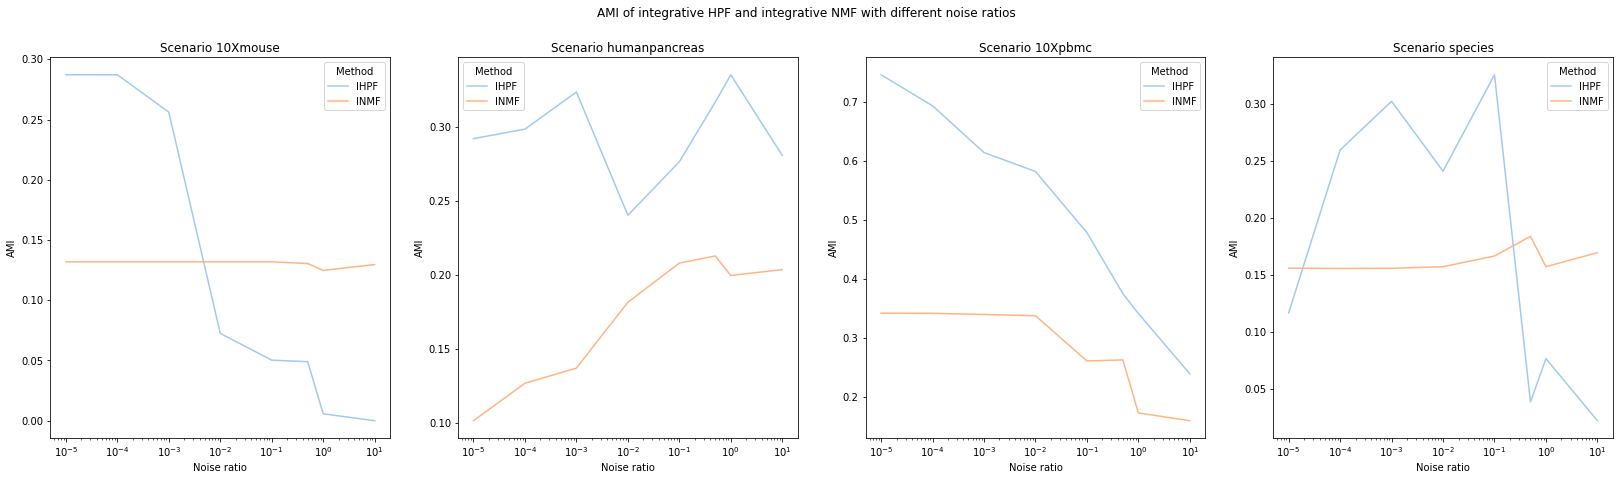

In [379]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(28, 7)
fig.suptitle('AMI of integrative HPF and integrative NMF with different noise ratios')
AMI = pd.DataFrame(actualAMI).reset_index()
AMI.columns = ['Method','Noise'] + datasets
for dataset_no in range(0,4):  
    # reshape multi index df into single index 
    df = AMI.pivot(index="Noise", columns="Method")[datasets[dataset_no]]
    df.plot(ax=axs[dataset_no], logx=True)
    axs[dataset_no].set(xlabel='Noise ratio', ylabel='AMI',title='Scenario {}'.format(datasets[dataset_no]))
plt.savefig('../Result/Grid_Search_AMI_v2.pdf'.format(datasets[dataset_no]),format='pdf')